# Sentiment Analysis - BERT

In [ ]:
%pip install kagglehub
%pip install pandas
%pip install -U jupyter ipywidgets
%pip install -U jupyterlab-widgets
%pip install seaborn
%pip install scikit-learn
%pip install nltk

## Caricamento dataset 

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import time
from collections import Counter
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForSequenceClassification
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")

# Download stopwords per la pulizia del testo
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

path = kagglehub.dataset_download("sainitishmitta04/23k-reddit-gaming-comments-with-sentiments-dataset")
file_path = os.path.join(path, "23k_r_gaming_comments_sentiments.csv")

df = pd.read_csv(file_path)

display(df.head())

,Unnamed: 0,Comment,sentiment
0,0,Them: I don't think I like this game.\n\nMe: B...,negative
1,1,Then you leave them to farm the smaller creatu...,negative
2,2,Nothing beats the feeling you get when you see...,positive
3,3,"[Also, they're made of paper](https://i.imgur....",negative
4,4,Haha... That was exactly it when my brother tr...,positive


In [2]:
# Dimensione del dataset
print(f"Numero di righe: {df.shape[0]}")
print(f"Numero di colonne: {df.shape[1]}")

# Tipi di dati
print("\nTipi di dati:")
print(df.dtypes)

# Valori mancanti
print("\nValori mancanti per colonna:")
print(df.isnull().sum())

Numero di righe: 23189
Numero di colonne: 3

Tipi di dati:
Unnamed: 0     int64
Comment       object
sentiment     object
dtype: object

Valori mancanti per colonna:
Unnamed: 0    0
Comment       0
sentiment     0
dtype: int64


## Preprocessing e esplorazione dataset

In [3]:
# Normalizzazione nomi colonne e pulizia dataset
RANDOM_STATE = 42

df_cleaned = df.copy()

# Rinomina colonne
df_cleaned = df_cleaned.rename(columns={'Comment': 'text'})
df_cleaned = df_cleaned.rename(columns={'sentiment': 'label'})

# Elimina colonna Unnamed: 0
df_cleaned = df_cleaned.drop(columns=['Unnamed: 0'])

# Pulisci i duplicati
df_cleaned = df_cleaned.drop_duplicates(subset=['text']).reset_index(drop=True)

# Statistiche finali
print(f"Dataset originale: {df.shape[0]} righe")
print(f"Dataset finale: {df_cleaned.shape[0]} righe, {df_cleaned.shape[1]} colonne")
print(f"Righe rimosse: {df.shape[0] - df_cleaned.shape[0]}")

df_cleaned.head()

Dataset originale: 23189 righe
Dataset finale: 21821 righe, 2 colonne
Righe rimosse: 1368


,text,label
0,Them: I don't think I like this game.\n\nMe: B...,negative
1,Then you leave them to farm the smaller creatu...,negative
2,Nothing beats the feeling you get when you see...,positive
3,"[Also, they're made of paper](https://i.imgur....",negative
4,Haha... That was exactly it when my brother tr...,positive


In [ ]:
def clean_text(text):
    # Rimuove link, caratteri speciali
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Rimuove menzioni e hashtag
    text = re.sub(r'\@\w+|\#', '', text) 
    # Mantiene solo lettere e numeri 
    text = re.sub(r"[^a-zA-Z0-9\s]", '', text)  
    # Rimuove stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in text.split() if w and w not in stop_words]
    text = ' '.join(words)
    # Converte in minuscolo
    text = text.lower()  
    return text.strip() 

# Applicare la pulizia
df_cleaned['text'] = df_cleaned['text'].apply(clean_text)

# Filtra e mantieni solo testi con 61 parole o meno
word_counts_before = df_cleaned['text'].apply(lambda x: len(str(x).split()))
df_cleaned = df_cleaned[word_counts_before <= 61].reset_index(drop=True)
print(f"Dataset dopo il filtraggio: {len(df_cleaned)} righe")

df_cleaned.head()

Dataset dopo il filtraggio: 21477 righe


,text,label
0,dont think like game havent even played 5 minu...,negative
1,leave farm smaller creatures either wait help ...,negative
2,nothing beats feeling get see fall love like y...,positive
3,also theyre made paper edit tried make gif fai...,negative
4,haha exactly brother tried get wow run raids g...,positive


Massimo numero di parole: 61
Commento con più parole: wife wanted play wow boosted couple alliance toons went fast forward yeti infested area drustvar stop pick flower druids wont health starts dropping fast wife help uhh ice block ice block runs dash surrounded least 20 mobs ice block faded hit cenarion ward wife best rotation going getting beat im gonna die healing heart youre fine everything fine managed kill mobs
Media del numero di parole: 9.75


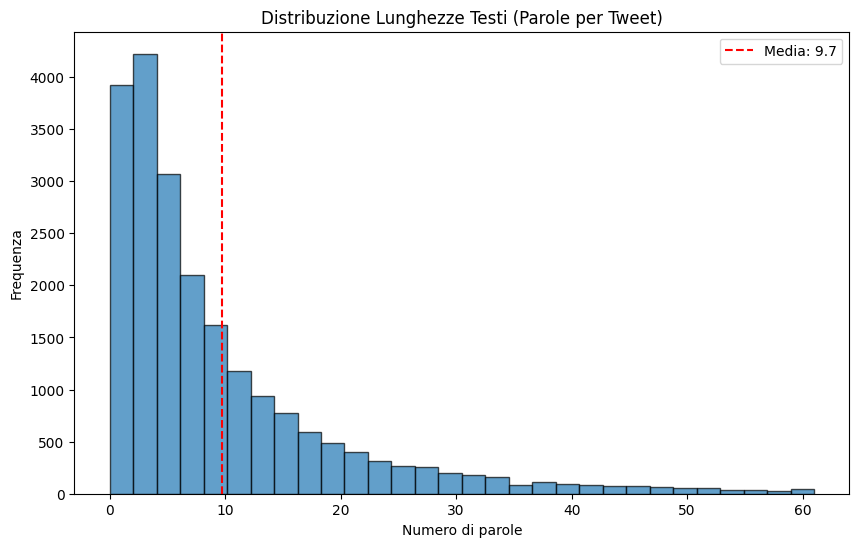

In [11]:
# Analisi delle lunghezze dei testi (parole per comment)

# Contare le parole in ogni testo pulito
word_counts = df_cleaned['text'].apply(lambda x: len(str(x).split()))

# Calcolare statistiche
max_word_count = word_counts.max()
max_word_index = word_counts.idxmax()
max_word_text = df_cleaned.loc[max_word_index, 'text']
mean_word_count = word_counts.mean()

print(f"Massimo numero di parole: {max_word_count}")
print(f"Commento con più parole: {max_word_text}")
print(f"Media del numero di parole: {mean_word_count:.2f}")

# Visualizzazione distribuzione lunghezze
plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=30, alpha=0.7, edgecolor='black')
plt.title('Distribuzione Lunghezze Testi (Parole per Tweet)')
plt.xlabel('Numero di parole')
plt.ylabel('Frequenza')
plt.axvline(mean_word_count, color='red', linestyle='--', label=f'Media: {mean_word_count:.1f}')
plt.legend()
plt.show()

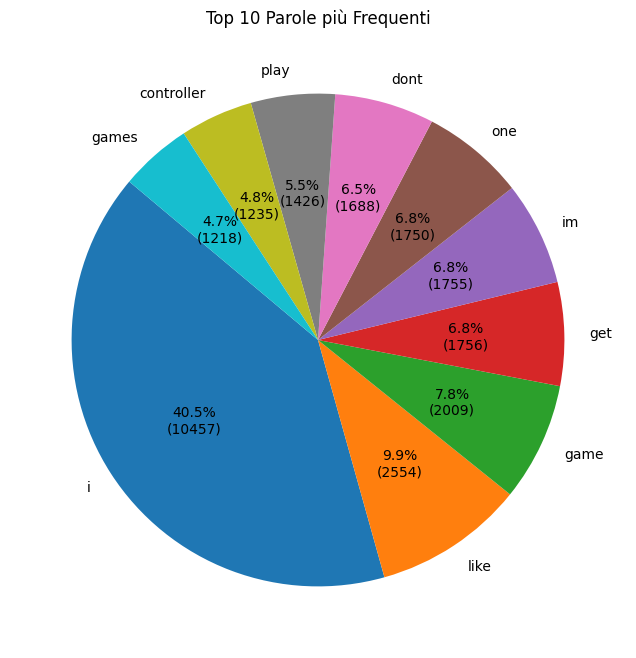

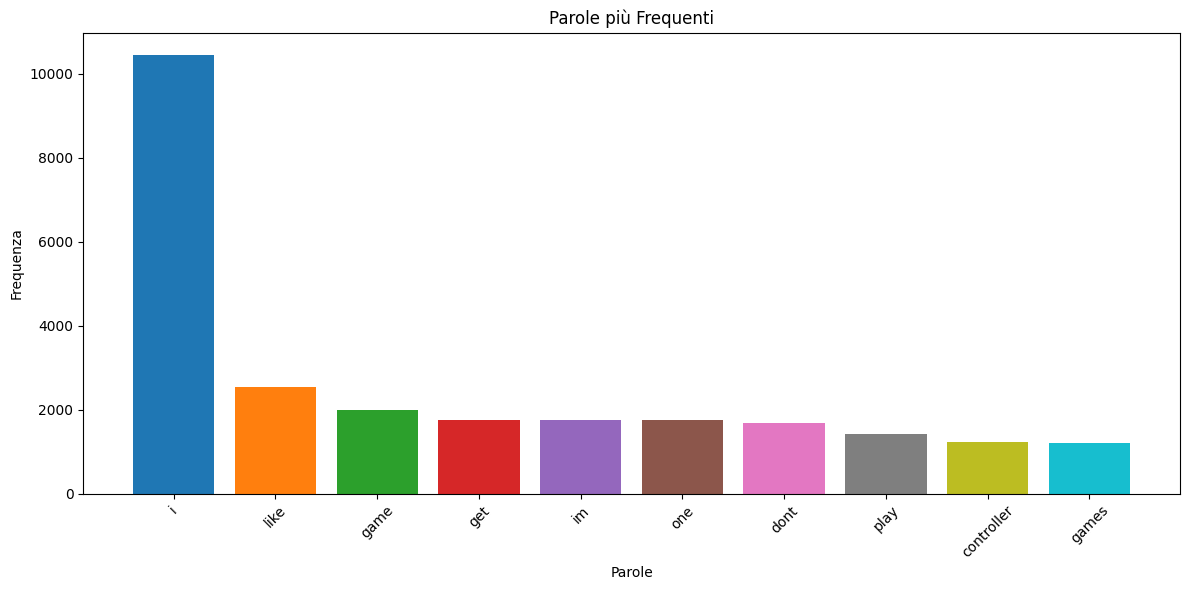

In [6]:
# Analisi delle parole più frequenti
all_words = ' '.join(df_cleaned['text']).split()
word_freq = Counter(all_words)

# Top 10 parole più frequenti
most_common_words = word_freq.most_common(10)
words, frequencies = zip(*most_common_words)

# Diagramma a torta delle parole più frequenti
def make_autopct(frequencies):
    def autopct(pct):
        total = sum(frequencies)
        count = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({count})'
    return autopct

plt.figure(figsize=(10, 8))
plt.pie(frequencies, labels=words, autopct=make_autopct(frequencies), startangle=140)
plt.title('Top 10 Parole più Frequenti')
plt.show()

# Grafico a barre delle parole più frequenti
plt.figure(figsize=(12, 6))
plt.bar(words, frequencies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                                   '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
plt.title('Parole più Frequenti')
plt.xlabel('Parole')
plt.ylabel('Frequenza')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Split stratificato train/val/test
X = df_cleaned['text']
y = df_cleaned['label']

print("Etichette uniche in y:")
print(y.unique())

# Prima divisione: train (70%) + temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

# Seconda divisione: val (15%) + test (15%) dal temp (30%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp)

print(f'\nTrain/Val/Test sizes: {X_train.shape[0]}/{X_val.shape[0]}/{X_test.shape[0]}')

Etichette uniche in y:
['negative' 'positive' 'neutral']

Train/Val/Test sizes: 14967/3207/3208


In [9]:
# Mappatura etichette da stringhe a numeri per BERT
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}

y_train = y_train.map(label_mapping)
y_val   = y_val.map(label_mapping)
y_test  = y_test.map(label_mapping)

print("\nValori unici in y_train:", y_train.unique())
print("NaN in y_train:", y_train.isna().sum())


Valori unici in y_train: [2 1 0]
NaN in y_train: 0


Negative: 2737 (18.3%)
Neutral: 5597 (37.4%)
Positive: 6633 (44.3%)


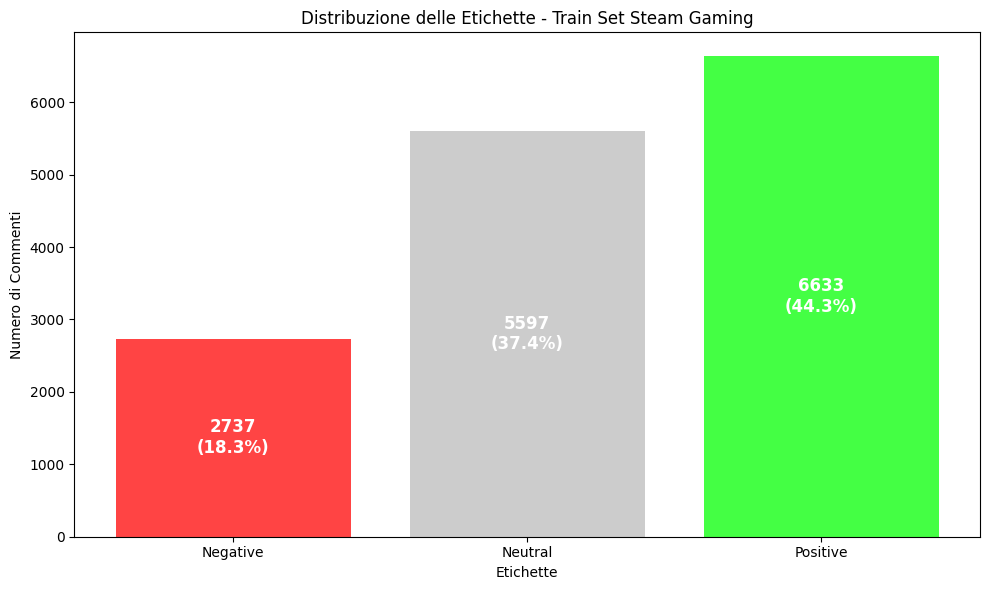

In [10]:
# Visualizzazione distribuzione delle etichette 
label_counts = y_train.value_counts().sort_index()
total_samples = len(y_train)

label_names = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
label_display = [label_names[i] for i in label_counts.index]


for i, count in label_counts.items():
    percentage = (count / total_samples) * 100
    print(f"{label_names.get(i, f'Label_{i}')}: {count} ({percentage:.1f}%)")

# Grafico a barre
plt.figure(figsize=(10, 6))
bars = plt.bar(label_display, label_counts.values, 
               color=['#ff4444', '#cccccc', '#44ff44'])
plt.title("Distribuzione delle Etichette - Train Set Steam Gaming")
plt.xlabel("Etichette")
plt.ylabel("Numero di Commenti")

# Aggiungi valori e percentuali al centro delle barre
for bar, count in zip(bars, label_counts.values):
    percentage = (count / total_samples) * 100
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, 
             f'{count}\n({percentage:.1f}%)', ha='center', va='center', 
             fontweight='bold', color='white', fontsize=12)

plt.tight_layout()
plt.show()

In [21]:
# Combina X_train e y_train in un unico DataFrame
df_train = pd.DataFrame({'text': X_train, 'label': y_train})

# Trova la classe minoritaria
min_samples = df_train['label'].value_counts().min()
print(f"\nCampioni classe minoritaria: {min_samples}")

# Undersampling
df_balanced = (
    df_train
        .groupby('label')
        .sample(n=min_samples, random_state=RANDOM_STATE)
        .sample(frac=1, random_state=RANDOM_STATE)   # shuffle finale
        .reset_index(drop=True)
)

# Ricostruisci X_train e y_train bilanciati
X_train = df_balanced['text']
y_train = df_balanced['label']

print("\nDataset bilanciato:")
print(f"Dimensione totale: {len(df_balanced)}")
print(y_train.value_counts().sort_index())




Campioni classe minoritaria: 2737

Dataset bilanciato:
Dimensione totale: 8211
label
0    2737
1    2737
2    2737
Name: count, dtype: int64


In [13]:
# Tokenizzazione e creazione DataLoader
BATCH_SIZE = 32
MAX_LEN = 64  

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenizza i dati
train_tokens = tokenizer(list(X_train), padding=True, truncation=True, return_tensors='pt', max_length=MAX_LEN)
val_tokens = tokenizer(list(X_val), padding=True, truncation=True, return_tensors='pt', max_length=MAX_LEN)
test_tokens = tokenizer(list(X_test), padding=True, truncation=True, return_tensors='pt', max_length=MAX_LEN)

# Crea dataset e DataLoader
train_dataset = TensorDataset(train_tokens['input_ids'], train_tokens['attention_mask'], torch.tensor(y_train.values, dtype=torch.long))
val_dataset = TensorDataset(val_tokens['input_ids'], val_tokens['attention_mask'], torch.tensor(y_val.values, dtype=torch.long))
test_dataset = TensorDataset(test_tokens['input_ids'], test_tokens['attention_mask'], torch.tensor(y_test.values, dtype=torch.long))

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'Train/Val/Test batches: {len(train_dataloader)}/{len(val_dataloader)}/{len(test_dataloader)}')

Train/Val/Test batches: 257/101/101


In [14]:
# Esempio di tokenizzazione
sample_text = X_train.iloc[0]

print(f"FRASE ORIGINALE:")
print(f"'{sample_text}'")
print(f"LUNGHEZZA: {len(sample_text.split())} parole")

# Tokenizza con encoding completo (include [CLS] e [SEP])
token_ids = tokenizer(sample_text, truncation=True, padding='max_length', max_length=MAX_LEN, return_tensors=None)

print(f"\nTABELLA TOKENIZZAZIONE:")
print(f"{'POS':<4} {'TOKEN':<25} {'TOKEN_ID':<10} {'TIPO':<15}")
print("-" * 65)

for i, token_id in enumerate(token_ids['input_ids']):
    # Decodifica il token ID per ottenere il token
    token = tokenizer.decode([token_id])
    
    # Determina il tipo di token
    if token_id == tokenizer.cls_token_id:
        token_type = "[CLS] - Inizio"
    elif token_id == tokenizer.sep_token_id:
        token_type = "[SEP] - Fine"  
    elif token_id == tokenizer.pad_token_id:
        token_type = "[PAD] - Padding"
    else:
        token_type = "Contenuto"
    
    print(f"{i+1:<4} {token:<25} {token_id:<10} {token_type:<15}")

FRASE ORIGINALE:
'just ask dad'
LUNGHEZZA: 3 parole

TABELLA TOKENIZZAZIONE:
POS  TOKEN                     TOKEN_ID   TIPO           
-----------------------------------------------------------------
1    [CLS]                     101        [CLS] - Inizio 
2    just                      2074       Contenuto      
3    ask                       3198       Contenuto      
4    dad                       3611       Contenuto      
5    [SEP]                     102        [SEP] - Fine   
6    [PAD]                     0          [PAD] - Padding
7    [PAD]                     0          [PAD] - Padding
8    [PAD]                     0          [PAD] - Padding
9    [PAD]                     0          [PAD] - Padding
10   [PAD]                     0          [PAD] - Padding
11   [PAD]                     0          [PAD] - Padding
12   [PAD]                     0          [PAD] - Padding
13   [PAD]                     0          [PAD] - Padding
14   [PAD]                     0          [PA

## BERT per Reddit Comments Sentiment Analysis

In [15]:
# Configura dispositivo (GPU se disponibile)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Dispositivo utilizzato: {device}")

# Imposta seed
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_STATE)
    torch.cuda.manual_seed_all(RANDOM_STATE)

# Carica modello BERT pre-addestrato
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model.to(device)

# Configura ottimizzatore
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)

# Configura funzione di loss
loss_fn = CrossEntropyLoss()

epochs = 3

# Inizializzazione liste per metriche di training e validazione
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

Dispositivo utilizzato: cpu


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Ciclo di addestramento principale
for epoch in range(epochs):
    print(f"\nEpoca {epoch + 1}/{epochs}")
    print("="*50)
    
    # Fase di training
    model.train()
    epoch_train_loss = 0
    epoch_correct = 0
    epoch_total = 0
    epoch_start_time = time.time()

    for step, batch in enumerate(train_dataloader):
        # Estrazione dati dal batch
        input_ids, attention_mask, labels = [data.to(device) for data in batch]

        # Reset gradienti
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        batch_loss = outputs.loss
        logits = outputs.logits

        # Accumula metriche
        epoch_train_loss += batch_loss.item()
        predictions = torch.argmax(logits, dim=1)
        epoch_correct += (predictions == labels).sum().item()
        epoch_total += labels.size(0)

        # Backward pass e ottimizzazione
        batch_loss.backward()
        optimizer.step()

        # Monitoraggio progresso ogni 10 batch
        if step % 10 == 0:
            elapsed = time.time() - epoch_start_time
            progress = (step + 1) / len(train_dataloader)
            eta = elapsed / progress - elapsed if progress > 0 else 0
            current_acc = epoch_correct / epoch_total * 100
            
            print(f"  Batch {step + 1}/{len(train_dataloader)} | "
                  f"Loss: {batch_loss.item():.4f} | "
                  f"Acc: {current_acc:.2f}% | "
                  f"ETA: {eta:.1f}s")

    # Calcola metriche finali training
    avg_train_loss = epoch_train_loss / len(train_dataloader)
    train_acc = epoch_correct / epoch_total
    
    # Fase di validazione
    model.eval()
    epoch_val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = [data.to(device) for data in batch]
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss = outputs.loss
            logits = outputs.logits
            
            epoch_val_loss += val_loss.item()
            predictions = torch.argmax(logits, dim=1)
            val_correct += (predictions == labels).sum().item()
            val_total += labels.size(0)
    
    # Calcola metriche finali validazione
    avg_val_loss = epoch_val_loss / len(val_dataloader)
    val_acc = val_correct / val_total
    
    # Salva metriche per visualizzazioni
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)
    
    # Report finale epoca
    epoch_time = time.time() - epoch_start_time
    print(f"\nRisultati Epoca {epoch + 1}:")
    print(f"   Training   - Loss: {avg_train_loss:.4f} | Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"   Validation - Loss: {avg_val_loss:.4f} | Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
    print(f"   Tempo epoca: {epoch_time:.1f}s")

print("\nAddestramento completato.")


Epoca 1/3
  Batch 1/257 | Loss: 1.0889 | Acc: 37.50% | ETA: 3637.8s
  Batch 11/257 | Loss: 1.1026 | Acc: 37.50% | ETA: 3066.7s
  Batch 21/257 | Loss: 1.1121 | Acc: 35.86% | ETA: 2991.4s
  Batch 31/257 | Loss: 1.0813 | Acc: 37.60% | ETA: 2967.8s
  Batch 41/257 | Loss: 1.0425 | Acc: 40.17% | ETA: 2774.0s
  Batch 51/257 | Loss: 1.0705 | Acc: 41.05% | ETA: 2614.5s
  Batch 61/257 | Loss: 1.0448 | Acc: 41.85% | ETA: 2601.9s
  Batch 71/257 | Loss: 1.0350 | Acc: 42.65% | ETA: 2462.5s
  Batch 81/257 | Loss: 1.0394 | Acc: 43.71% | ETA: 2326.9s
  Batch 91/257 | Loss: 0.9976 | Acc: 44.68% | ETA: 2179.0s
  Batch 101/257 | Loss: 1.0120 | Acc: 45.64% | ETA: 2023.5s
  Batch 111/257 | Loss: 0.8652 | Acc: 46.96% | ETA: 1870.6s
  Batch 121/257 | Loss: 0.7870 | Acc: 48.17% | ETA: 1730.0s
  Batch 131/257 | Loss: 0.9571 | Acc: 49.05% | ETA: 1592.0s
  Batch 141/257 | Loss: 0.7261 | Acc: 50.40% | ETA: 1459.3s
  Batch 151/257 | Loss: 0.8274 | Acc: 51.49% | ETA: 1327.6s
  Batch 161/257 | Loss: 0.6817 | Acc: 52

In [17]:
# Evaluazione finale su test set
print("EVALUAZIONE FINALE SU TEST SET")

model.eval()
all_preds = []
all_labels = []
total_test_loss = 0
correct_test_predictions = 0
total_test_predictions = 0

test_start_time = time.time()

with torch.no_grad():
    for batch in test_dataloader:
        b_input_ids, b_attention_mask, b_labels = [x.to(device) for x in batch]
        outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask)
        loss = loss_fn(outputs.logits, b_labels)

        total_test_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        labels = b_labels.cpu().numpy()

        correct_test_predictions += (preds == labels).sum()
        total_test_predictions += len(labels)
        all_preds.extend(preds)
        all_labels.extend(labels)

avg_test_loss = total_test_loss / len(test_dataloader)
test_accuracy = correct_test_predictions / total_test_predictions
test_time = time.time() - test_start_time

print("RISULTATI TEST:")
print(f"   Loss: {avg_test_loss:.4f}")
print(f"   Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.1f}%)")
print(f"   Tempo: {test_time:.1f}s")

EVALUAZIONE FINALE SU TEST SET
RISULTATI TEST:
   Loss: 0.5471
   Accuracy: 0.7949 (79.5%)
   Tempo: 288.7s


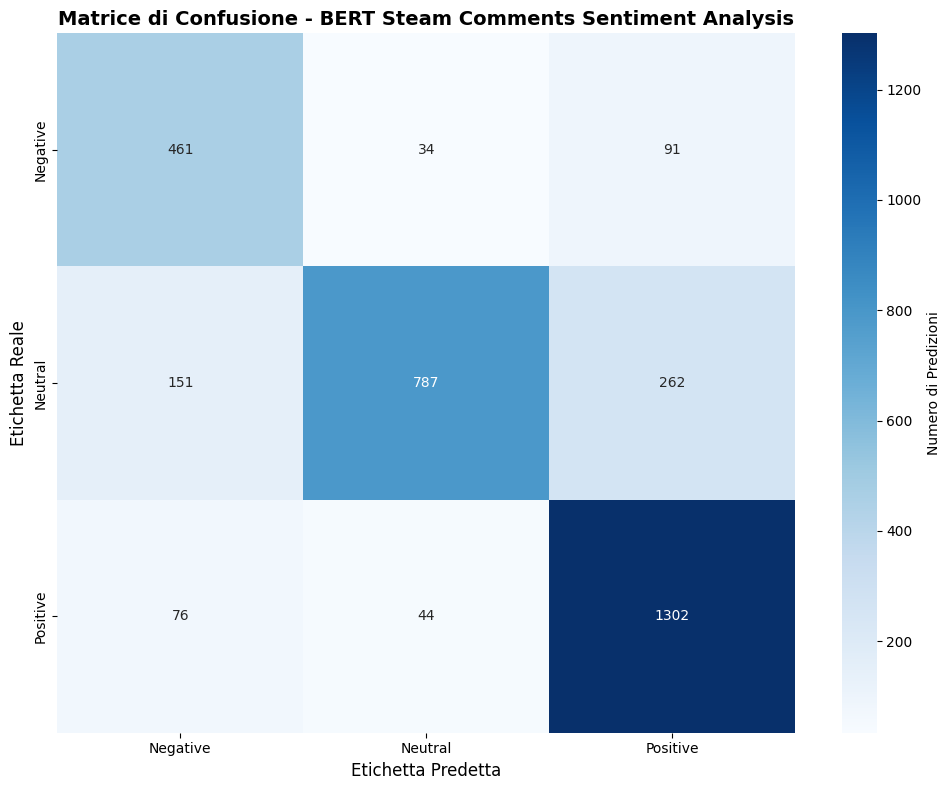

REPORT DI CLASSIFICAZIONE:
CLASSE       PRECISION    RECALL       F1-SCORE     SUPPORT   
----------------------------------------------------------------------
Negative     0.6701       0.7867       0.7237       586       
Neutral      0.9098       0.6558       0.7622       1200      
Positive     0.7867       0.9156       0.8463       1422      
----------------------------------------------------------------------
MACRO AVG    0.7889       0.7860       0.7774       3208      
WEIGHTED AVG 0.8115       0.7949       0.7924       3208      


In [18]:
# Nomi delle classi per il report
class_names = ['Negative', 'Neutral', 'Positive']

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Visualizzazione Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Numero di Predizioni'})
plt.xlabel('Etichetta Predetta', fontsize=12)
plt.ylabel('Etichetta Reale', fontsize=12)
plt.title('Matrice di Confusione - BERT Steam Comments Sentiment Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Metriche dettagliate per classe
print("REPORT DI CLASSIFICAZIONE:")

# Calcola precision, recall, F1-score e support per ogni classe
precision, recall, fscore, support = precision_recall_fscore_support(all_labels, all_preds, average=None)

# Crea tabella formattata
print(f"{'CLASSE':<12} {'PRECISION':<12} {'RECALL':<12} {'F1-SCORE':<12} {'SUPPORT':<10}")
print("-" * 70)

for i, class_name in enumerate(class_names):
    print(f"{class_name:<12} {precision[i]:<12.4f} {recall[i]:<12.4f} {fscore[i]:<12.4f} {support[i]:<10}")

# Metriche aggregate
precision_avg = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
macro_avg = precision_recall_fscore_support(all_labels, all_preds, average='macro')

print("-" * 70)
print(f"{'MACRO AVG':<12} {macro_avg[0]:<12.4f} {macro_avg[1]:<12.4f} {macro_avg[2]:<12.4f} {sum(support):<10}")
print(f"{'WEIGHTED AVG':<12} {precision_avg[0]:<12.4f} {precision_avg[1]:<12.4f} {precision_avg[2]:<12.4f} {sum(support):<10}")

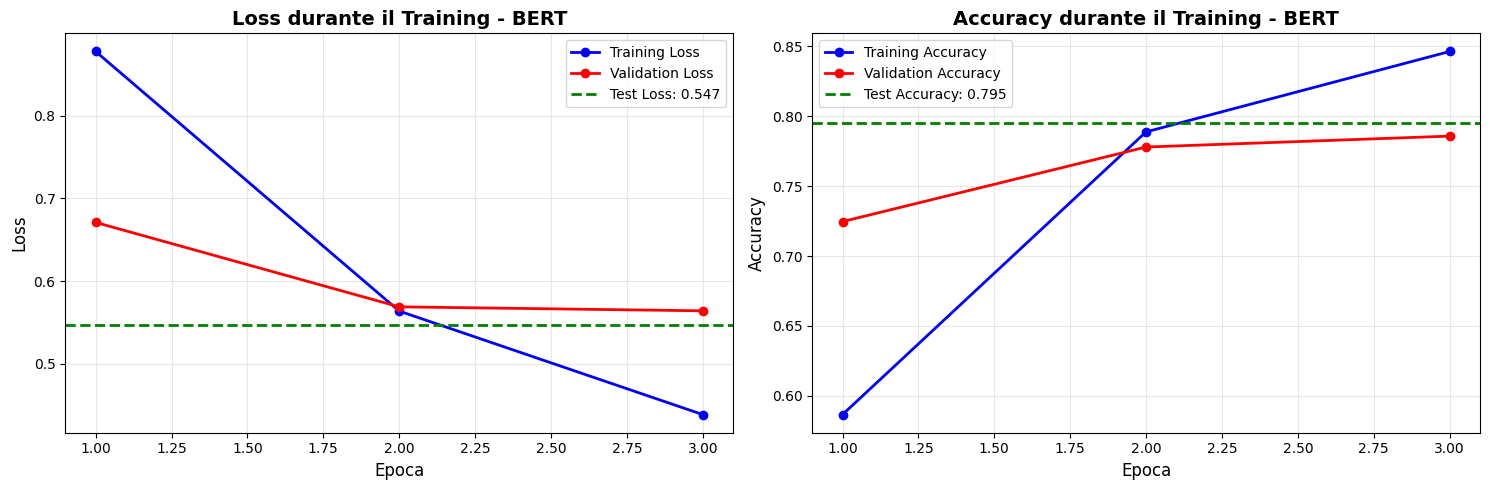

RIASSUNTO PERFORMANCE MODELLO
Metrica              Training     Validation   Test        
------------------------------------------------------------
Loss finale          0.4383       0.5640       0.5471      
Accuracy finale      0.8463       0.7858       0.7949      
Accuracy %           84.6         78.6         79.5        

Training completato per 3 epoche
Dataset: 14626 campioni totali
Split: 8211 train, 3207 val, 3208 test


In [22]:
# Grafici delle metriche di training
plt.figure(figsize=(15, 5))

# Grafico Loss: Training vs Validation
plt.subplot(1, 2, 1)
epochs_range = range(1, len(train_losses) + 1)
plt.plot(epochs_range, train_losses, 'bo-', label='Training Loss', linewidth=2, markersize=6)
plt.plot(epochs_range, val_losses, 'ro-', label='Validation Loss', linewidth=2, markersize=6)
plt.axhline(y=avg_test_loss, color='green', linestyle='--', linewidth=2, label=f'Test Loss: {avg_test_loss:.3f}')
plt.title('Loss durante il Training - BERT', fontsize=14, fontweight='bold')
plt.xlabel('Epoca', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Grafico Accuracy: Training vs Validation
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, 'bo-', label='Training Accuracy', linewidth=2, markersize=6)
plt.plot(epochs_range, val_accuracies, 'ro-', label='Validation Accuracy', linewidth=2, markersize=6)
plt.axhline(y=test_accuracy, color='green', linestyle='--', linewidth=2, label=f'Test Accuracy: {test_accuracy:.3f}')
plt.title('Accuracy durante il Training - BERT', fontsize=14, fontweight='bold')
plt.xlabel('Epoca', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tabella riassuntiva finale
print("RIASSUNTO PERFORMANCE MODELLO")
print(f"{'Metrica':<20} {'Training':<12} {'Validation':<12} {'Test':<12}")
print("-" * 60)
print(f"{'Loss finale':<20} {train_losses[-1]:<12.4f} {val_losses[-1]:<12.4f} {avg_test_loss:<12.4f}")
print(f"{'Accuracy finale':<20} {train_accuracies[-1]:<12.4f} {val_accuracies[-1]:<12.4f} {test_accuracy:<12.4f}")
print(f"{'Accuracy %':<20} {train_accuracies[-1]*100:<12.1f} {val_accuracies[-1]*100:<12.1f} {test_accuracy*100:<12.1f}")

print(f"\nTraining completato per {epochs} epoche")
print(f"Dataset: {len(X_train) + len(X_val) + len(X_test)} campioni totali")
print(f"Split: {len(X_train)} train, {len(X_val)} val, {len(X_test)} test")